# Load modules

In [1]:
# %matplotlib notebook
import os
import xml.etree.ElementTree as ET
from struct import unpack, iter_unpack
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks, find_peaks_cwt, spectrogram, convolve, detrend, hilbert
from scipy.fft import rfft, rfftfreq, fftshift
from scipy.interpolate import griddata
from scipy.integrate import simpson, cumulative_trapezoid
from scipy.optimize import curve_fit, minimize
import enum
from dataclasses import dataclass
from rpspy import get_linearization, linearize, indep_roll, profile_inversion, f_to_ne, get_sampling_frequency, get_antenna_position, aug_tgcorr2, get_band_signal, get_linearization_reference, get_default_shotfile_dir
import scipy.constants as cst
from ipfnpytools.trz_to_rhop import fast_trz_to_rhop, trz_to_rhop
import matplotlib.colors as colors
from scipy.interpolate import UnivariateSpline
import waveguide_dispersion

10:58:20 | aug_sfutils | INFO: Using version 0.8.0
10:58:20 | aug_sfutils.ww | INFO: WW loaded
10:58:20 | aug_sfutils.sfh | INFO: SFH loaded
10:58:20 | aug_sfutils.mapeq | INFO: AUG-SF home /shares/software/aug-dv/moduledata/aug_sfutils/0.8.0/aug_sfutils


In [2]:
# Spectrogram options
_spectrogram_options = {
    'K': {'nperseg': 128, 'noverlap':96, 'nfft': 2048},
    'Ka': {'nperseg': 128, 'noverlap':96, 'nfft': 2048},
    'Q': {'nperseg': 128, 'noverlap':96, 'nfft': 2048},
    'V': {'nperseg': 32, 'noverlap':24, 'nfft': 2048},
}


def normalize(x, n=1, axis=-1):
    return x / np.max(np.abs(x), axis=axis) * n


@dataclass
class Band:
    name: str
    side: str
    dtype: str
    frequency: np.ndarray = 0
    amplitude: np.ndarray = 0
    fs: float = 0.0
    nperseg: int = 0
    noverlap: int = 0
    nfft: int = 0
    x: np.ndarray = 0
    y: np.ndarray = 0
    spectrogram: np.ndarray = 0
    bg_spectrogram: np.ndarray = 0
    spectrogram_corrected: np.ndarray = 0
    x_sampled: np.ndarray = 0
    y_sampled: np.ndarray = 0
    spectrogram_sampled: np.ndarray = 0
    dispersion: np.ndarray = 0
        
    def __init__(self, name, side, dtype):
        self.name = name
        self.side = side
        self.dtype = dtype
        
        self.nperseg = _spectrogram_options[self.name]['nperseg']
        self.noverlap = _spectrogram_options[self.name]['noverlap']
        self.nfft = _spectrogram_options[self.name]['nfft']


def compute_spectrograms(band):
    
    # Compute spectrograms ---------------------------------------------------------------------------------------------------------------

    band.y, band.x, band.spectrogram = spectrogram(
        band.amplitude,
        fs=band.fs,
        nperseg=band.nperseg, 
        noverlap=band.noverlap, 
        nfft=band.nfft,
#         window='hamming',
#         return_onesided=False,
#         mode='magnitude',
#         scaling='spectrum',
    )
#     print(band.spectrogram.shape)

    # Normalize spectrograms -------------------------------
#     band.spectrogram /= band.spectrogram.max(axis=0)

    # Remap the x-axis to frequency domain -----------------
    band.x = band.frequency[0] + band.x * (band.frequency[-1] - band.frequency[0]) / 25e-6 
    
    if band.amplitude.dtype == complex:
        band.y = fftshift(band.y)
        band.spectrogram = fftshift(band.spectrogram, axes=-2)
    
    return band

In [3]:
shot = 40083
shotfile_dir = get_default_shotfile_dir(shot)
print(f"Analysing shot #{shot}. Raw data fetched from {shotfile_dir}")

sampling_frequency = get_sampling_frequency(shot, shotfile_dir)
print(f"Sampling frequency {sampling_frequency*1e-6} MHz")


# Get reference shot number and sweep number for linearization 
shot_linearization, sweep_linearization = get_linearization_reference(shot)
linearization_shotfile_dir = get_default_shotfile_dir(shot_linearization)
print(f"Using linearization from shot #{shot_linearization} at sweep number {sweep_linearization}")


# Set the positions of the inner and outer limiters
# These positions are used for initialization later on
inner_limiter = 1.045
outer_limiter = 2.206

# Calculate the equivalent group delay of each limiter position
# With respect to the reference antenna for each side
hfs_gd_zero = 2 * abs(inner_limiter - get_antenna_position('hfs')) / cst.c * 1e9
lfs_gd_zero = 2 * abs(outer_limiter - get_antenna_position('lfs')) / cst.c * 1e9

# Use only these bands
used_bands = [
    ('K', 'real'), 
    ('Ka', 'real'), 
    ('Q', 'real'), 
#     ('V', 'complex')
]

Analysing shot #40083. Raw data fetched from /shares/experiments/aug-rawfiles/RTR/4008/40083/
Sampling frequency 40.0 MHz
Using linearization from shot #40112 at sweep number 24


# Measure the background signal

In [4]:
# Select time instant for measuring background (ideally at zero seconds)
time_instant = 0.000
sweep = np.rint(time_instant / 35e-6).astype(int)

# Select the number of sweeps (burst size) for background signal averaging
burst_bg = 51
print(f"Averaging background for {burst_bg} starting from sweep {sweep}")

# Instantiate a list to hold a "Band" object for each microwave band on each side
bands_bg = [Band(name, side, dtype) for side in ['HFS', 'LFS'] for name, dtype in used_bands]

for band in bands_bg:
    
    # Sampling frequency
    band.fs = sampling_frequency
    
    # Get the frequency curve of each band
    # Using the linearization procedure
    frequency = get_linearization(shot_linearization, sweep_linearization, band.name, shotfile_dir=linearization_shotfile_dir)

    # Read the raw data from the database to measure the background signal
    signal = get_band_signal(shot, shotfile_dir, band.name, band.side, band.dtype, sweep, burst_bg)

    # Use the frequency curve to apply linearization to each sweep
    for i in range(burst_bg):
        frequency_linear, signal[i] = linearize(frequency, signal[i])   
        
    # Save the linearized signal to the "Band" data structure
    band.frequency = frequency_linear
    band.sweep_rate = (band.frequency[1] - band.frequency[0]) * band.fs
    band.amplitude = signal


# Compute spectrograms
for band in bands_bg:
    band = compute_spectrograms(band)
    # Average all spectrograms
    band.burst_spectrogram = band.spectrogram.mean(axis=0)
    
    
# Choose which bands to subtract backgroundfrom -----------------------------
subtract_on_bands = ['Q-HFS', 'Q-LFS']

for band in bands_bg:
    if f"{band.name}-{band.side}" in subtract_on_bands:
        continue
    else:
        band.burst_spectrogram *= 0
        
# Apply filters to the background --------------------------------
# bg_filters = {
#     'HFS': {
#         'K': [0.0e6, 4.0e6],
#         'Ka': [0.0e6, 4.0e6],
#         'Q': [2e6, 6e6],
#         'V': [-20.0e6, 20e6],
#     },
#     'LFS': {
#         'K': [0.0e6, 4.0e6],
#         'Ka': [0.0e6, 4.0e6],
#         'Q': [1.7e6, 3.3e6],
#         'V': [-20.0e6, 20.0e6],
#     },
# }


# for band in bands_bg:
    
#     band.upper_filter = bg_filters[band.side][band.name][1]
#     band.lower_filter = bg_filters[band.side][band.name][0]

#     try:
#         band.burst_spectrogram[np.broadcast_to(band.y[:, None], band.burst_spectrogram.shape) > band.upper_filter] = 0
#         band.burst_spectrogram[np.broadcast_to(band.y[:, None], band.burst_spectrogram.shape) < band.lower_filter] = 0
# #         band.spectrogram_filtered = normalize(band.spectrogram_filtered, axis=0)
#     except AttributeError:
#         pass

Averaging background for 51 starting from sweep 0


# Inspect background

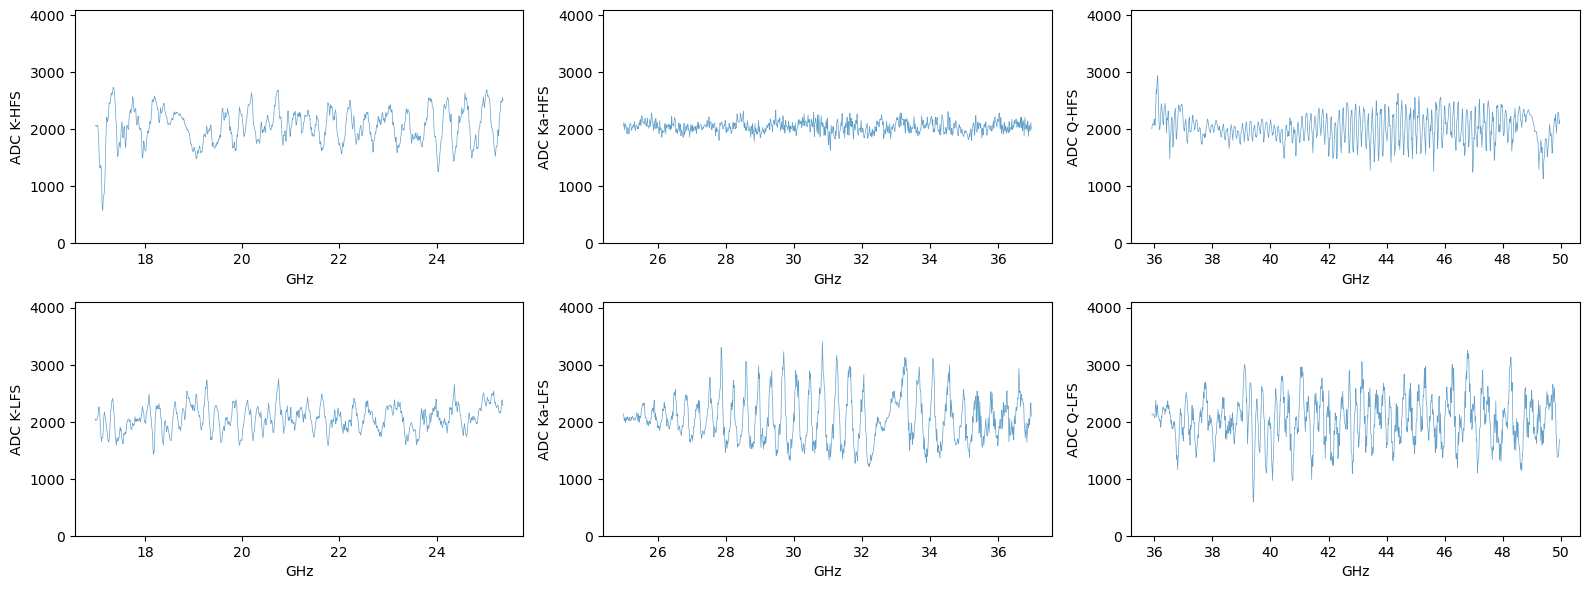

In [5]:
fig, axes = plt.subplots(2, len(used_bands), figsize=(16, 6))

for band, ax in zip(bands_bg, axes.flatten()):
    plt.sca(ax)
    plt.plot(band.frequency*1e-9, np.real(band.amplitude[0]), lw=0.5, alpha=0.7)
    if band.dtype == 'complex':
        plt.plot(band.frequency*1e-9, np.imag(band.amplitude[0]), lw=0.5, alpha=0.7)
        
    plt.ylabel(f"ADC {band.name}-{band.side}")
    plt.xlabel(f"GHz")
    plt.ylim(0, 2**12)
    
plt.tight_layout()

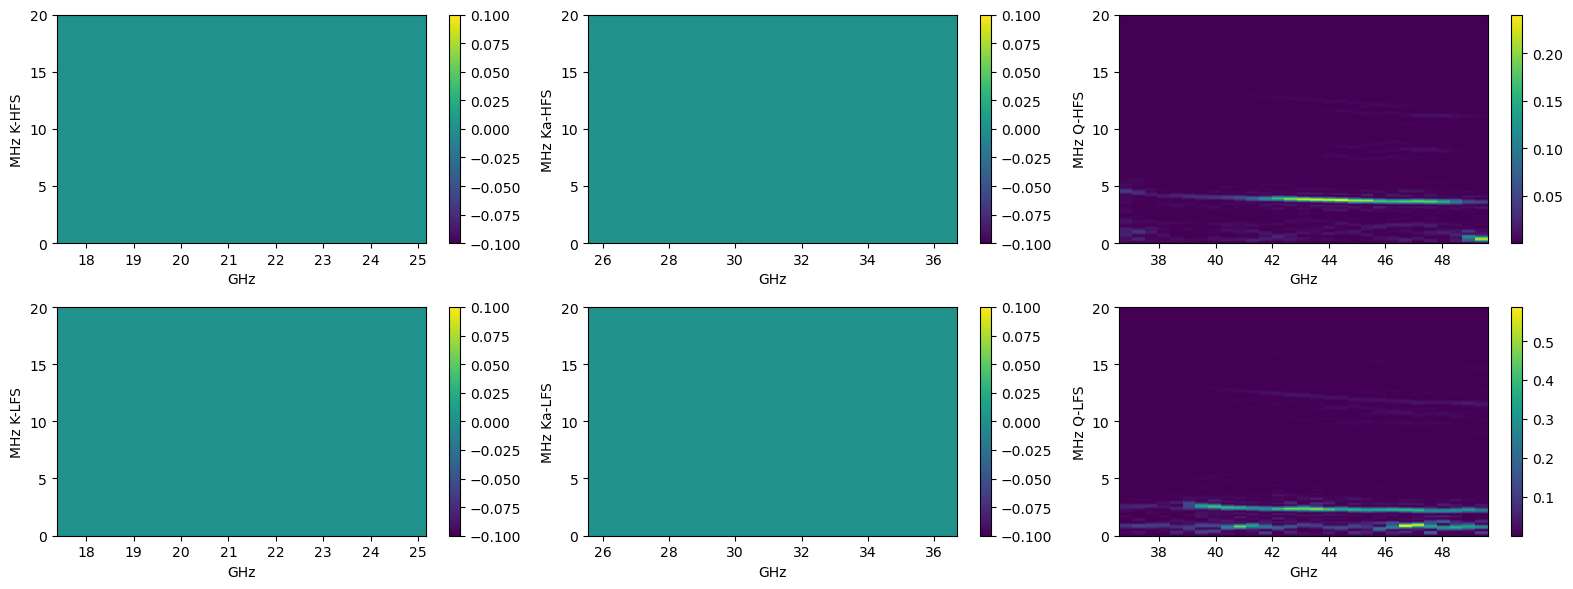

In [6]:
fig, axes = plt.subplots(2, len(used_bands), figsize=(16, 6))

for band, ax in zip(bands_bg, axes.flatten()):
    plt.sca(ax)
#     plt.pcolormesh(band.x * 1e-9, band.y * 1e-6, band.burst_spectrogram, shading='nearest')
    plt.pcolormesh(band.x * 1e-9, band.y * 1e-6, 
                   band.burst_spectrogram, 
#                    band.burst_spectrogram - band.bg_burst_spectrogram,
#                    np.clip(band.burst_spectrogram - band.bg_spectrogram, a_min=0, a_max=np.inf),
                   shading='nearest', 
#                    norm=colors.LogNorm(vmin=band.burst_spectrogram.min(), vmax=band.burst_spectrogram.max()),
#                    vmin=0,
#                    vmax=8,
                  )
#     plt.pcolormesh(band.x * 1e-9, band.y_corrected * 1e-6, band.burst_spectrogram, shading='nearest')
#     plt.plot(band.x * 1e-9, band.dispersion * 1e-6, color='C1')
    plt.colorbar()
    plt.ylabel(f"MHz {band.name}-{band.side}")
    plt.xlabel(f"GHz")
#     plt.plot(band.x * 1e-9, band.dispersion2 * 1e-6, color='C2')
#     plt.xlim(None, 47)
#     plt.ylim(1.0, 4.0)
    
plt.tight_layout()

# Calculate the density profile for a given time

In [7]:
# Choose time instant and number of sweeps (burst size)
time_instant = 4.5
burst = 51

# Calculate sweep number from time_instant
sweep = np.rint(time_instant / 35e-6).astype(int)
print(f"Measuring signal starting from sweep {sweep} using burst size {burst}")

# Instantiate a list to hold a "Band" object for each microwave band on each side
bands = [Band(name, side, dtype) for side in ['HFS', 'LFS'] for name, dtype in used_bands]

for band in bands:
    
    # Sampling frequency
    band.fs = sampling_frequency
    
    # Get the frequency curve of each band
    # Using the linearization procedure
    frequency = get_linearization(shot_linearization, sweep_linearization, band.name, shotfile_dir=linearization_shotfile_dir)

    # Read the raw data from the database to measure the background signal
    signal = get_band_signal(shot, shotfile_dir, band.name, band.side, band.dtype, sweep, burst)

    # Use the frequency curve to apply linearization to each sweep
    for i in range(burst):
        frequency_linear, signal[i] = linearize(frequency, signal[i])   
        
    # Save the linearized signal to the "Band" data structure
    band.frequency = frequency_linear
    band.sweep_rate = (band.frequency[1] - band.frequency[0]) * band.fs
    band.amplitude = signal   

Measuring signal starting from sweep 128571 using burst size 51


# Inspect the raw signals

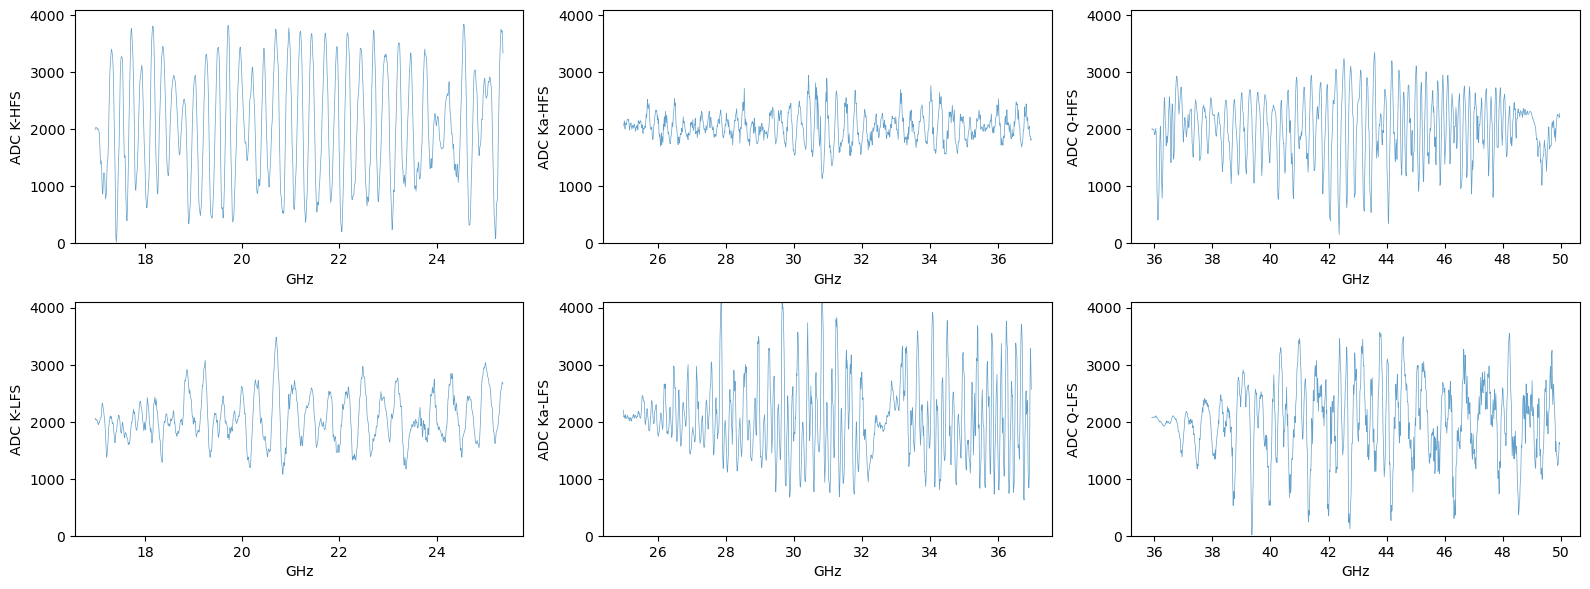

In [8]:
fig, axes = plt.subplots(2, len(used_bands), figsize=(16, 6))

for band, ax in zip(bands, axes.flatten()):
    plt.sca(ax)
    plt.plot(band.frequency*1e-9, np.real(band.amplitude[0]), lw=0.5, alpha=0.7)
    if band.dtype == 'complex':
        plt.plot(band.frequency*1e-9, np.imag(band.amplitude[0]), lw=0.5, alpha=0.7)
        
    plt.ylabel(f"ADC {band.name}-{band.side}")
    plt.xlabel(f"GHz")
    plt.ylim(0, 2**12)
    
plt.tight_layout()

In [9]:
# Compute spectrograms
for band in bands:
    band = compute_spectrograms(band)
    band.burst_spectrogram = band.spectrogram.mean(axis=0)

# Copy both signal and background to the same "Band" data structure 
for band, bg in zip(bands, bands_bg):
    band.bg_spectrogram = np.array(bg.burst_spectrogram)

In [10]:
# Get the dispersion curve for each band (based on system calibration)
for band in bands:
    
    tau_offset = aug_tgcorr2(band.name, band.side, band.x * 1e-9, shot, ws='64', verbose=False)
    band.dispersion = tau_offset * (band.frequency[1] - band.frequency[0]) * band.fs 

# Inpect the spectrograms

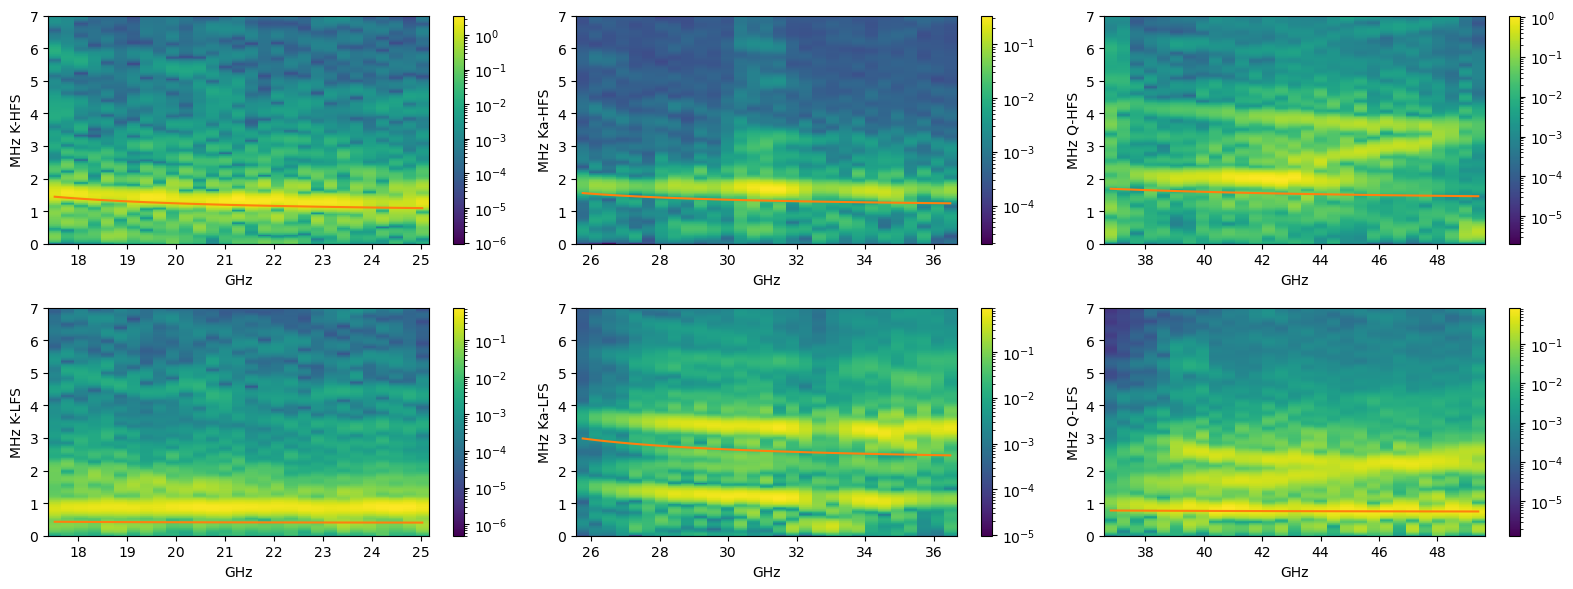

In [11]:
fig, axes = plt.subplots(2, len(used_bands), figsize=(16, 6))

for band, ax in zip(bands, axes.flatten()):
    plt.sca(ax)
#     plt.pcolormesh(band.x * 1e-9, band.y * 1e-6, band.burst_spectrogram, shading='nearest')
    plt.pcolormesh(band.x * 1e-9, band.y * 1e-6, 
                   band.burst_spectrogram, 
#                    np.clip(band.burst_spectrogram - band.bg_spectrogram, a_min=np.min(band.burst_spectrogram), a_max=np.inf),
#                    band.burst_spectrogram - band.bg_spectrogram,
#                    shading='nearest', 
                   norm=colors.LogNorm(vmin=band.burst_spectrogram.min(), vmax=band.burst_spectrogram.max()),
#                    vmin=0,
#                    vmax=8,
                   shading='nearest',
                  )
#     plt.pcolormesh(band.x * 1e-9, band.y_corrected * 1e-6, band.burst_spectrogram, shading='nearest')
    plt.plot(band.x * 1e-9, band.dispersion * 1e-6, color='C1')
    plt.colorbar()
    plt.ylabel(f"MHz {band.name}-{band.side}")
    plt.xlabel(f"GHz")
#     plt.plot(band.x * 1e-9, band.dispersion2 * 1e-6, color='C2')
#     plt.xlim(None, 47)
    plt.ylim(0, 7.0)
    
plt.tight_layout()

# Correct for the dispersion and subtract background

In [12]:
# Process the raw data
for band in bands:
    
    # Alias ------------------------------------
    sxx = band.burst_spectrogram         
    beat_offset = band.dispersion
    y_axis = band.y
    # ------------------------------------------
    
    # Copy into new spectrogram
    sxx_rolled = np.array(sxx)  
    
    # Subtract background
    sxx_rolled -= band.bg_spectrogram  
    
    # Zero the values bellow dispersion
    sxx_rolled[np.broadcast_to(y_axis[:, None], sxx.shape) <= beat_offset] = sxx_rolled.min()

    # Shift (roll) each fft slice according to the dispersion
    sxx_rolled = indep_roll(
        sxx_rolled, 
        -np.argmax(np.broadcast_to(y_axis[:, None], sxx.shape) > beat_offset, axis=0), 
        axis=0,
    )

    # Renormalize after rolling
#     sxx_rolled /= sxx_rolled.max(axis=0)

    # Normalize the burst spectrogram
#     band.burst_spectrogram /= band.burst_spectrogram.max(axis=0)
     
    
    # Assign
    band.spectrogram_corrected = sxx_rolled
    band.y_corrected = band.y - band.y[0]

# Inspect spectrograms corrected and with background subtracted

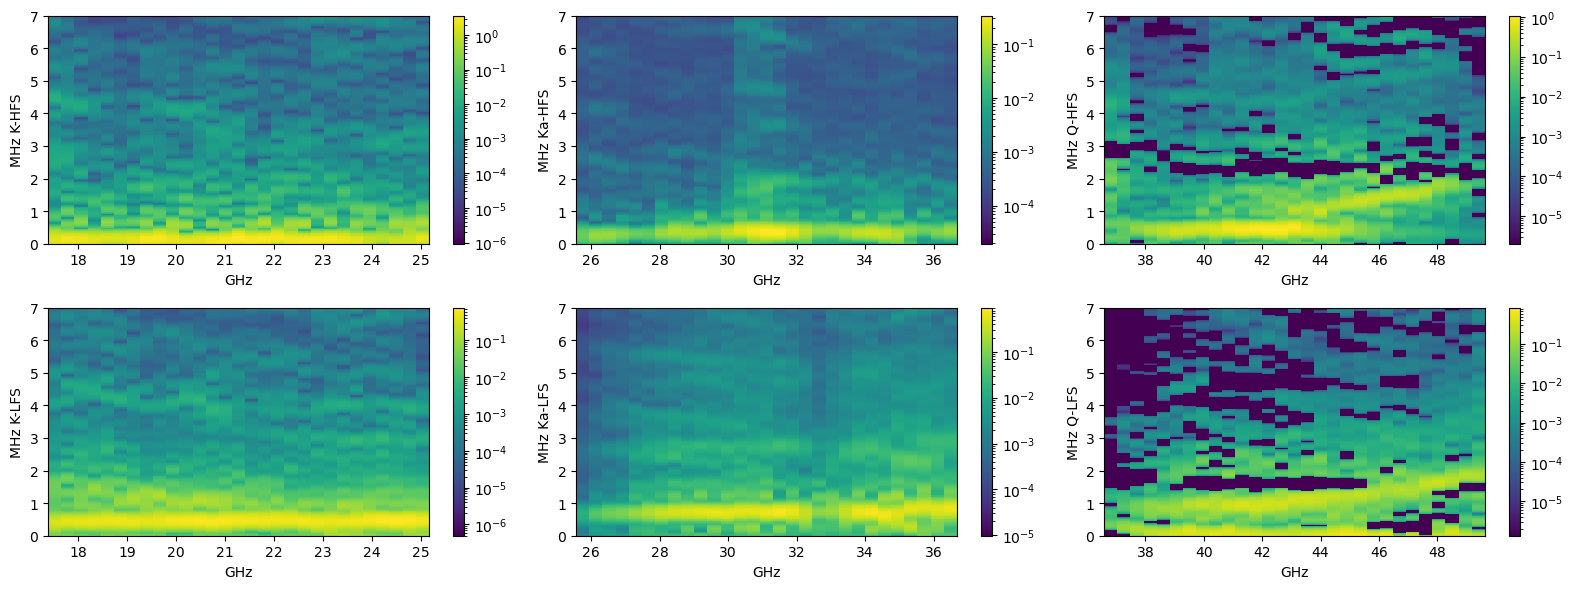

In [13]:
fig, axes = plt.subplots(2, len(used_bands), figsize=(16, 6))

for band, ax in zip(bands, axes.flatten()):
    plt.sca(ax)
#     plt.pcolormesh(band.x * 1e-9, band.y * 1e-6, band.burst_spectrogram, shading='nearest')
    plt.pcolormesh(band.x * 1e-9, band.y_corrected * 1e-6, 
#                    band.burst_spectrogram, 
#                    np.clip(band.burst_spectrogram - band.bg_spectrogram, a_min=np.min(band.burst_spectrogram), a_max=np.inf),
#                    band.burst_spectrogram - band.bg_spectrogram,
                   np.clip(band.spectrogram_corrected, a_min=np.min(band.burst_spectrogram), a_max=np.inf),
#                    shading='nearest', 
                   norm=colors.LogNorm(vmin=band.burst_spectrogram.min(), vmax=band.burst_spectrogram.max()),
#                    vmin=0,
#                    vmax=8,
                   shading='nearest',
                  )
#     plt.pcolormesh(band.x * 1e-9, band.y_corrected * 1e-6, band.burst_spectrogram, shading='nearest')
#     plt.plot(band.x * 1e-9, band.dispersion * 1e-6, color='C1')
    plt.colorbar()
    plt.ylabel(f"MHz {band.name}-{band.side}")
    plt.xlabel(f"GHz")
#     plt.plot(band.x * 1e-9, band.dispersion2 * 1e-6, color='C2')
#     plt.xlim(None, 47)
    plt.ylim(0, 7.0)
    
plt.tight_layout()

# Apply frequency filters

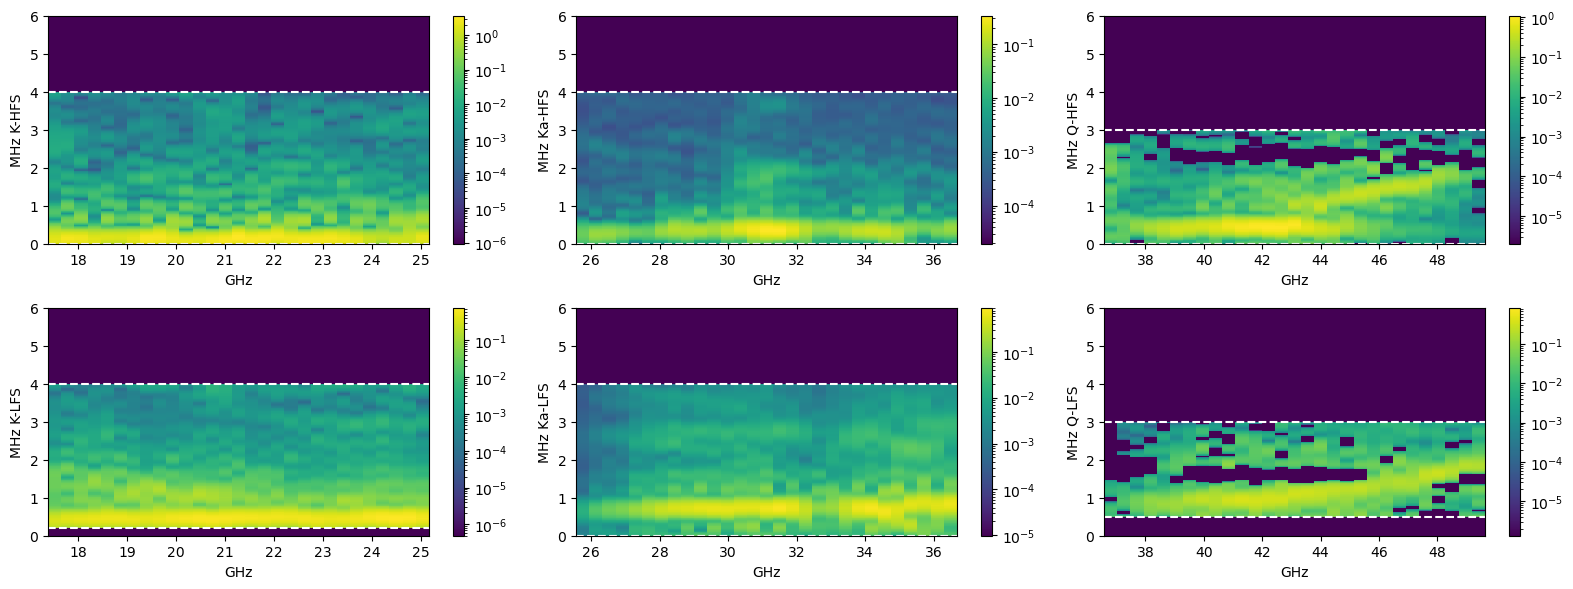

In [14]:
filters = {
    'HFS': {
        'K': [0.0e6, 4.0e6],
        'Ka': [0.0e6, 4.0e6],
        'Q': [0.0e6, 3.0e6],
        'V': [0.0e6, 6.0e6],
    },
    'LFS': {
        'K': [0.2e6, 4.0e6],
        'Ka': [0.0e6, 4.0e6],
        'Q': [0.5e6, 3.0e6],
        'V': [0.8e6, 6.0e6],
    },
}


for band in bands:
        band.upper_filter = filters[band.side][band.name][1]
        band.lower_filter = filters[band.side][band.name][0]


for band in bands:
    
    band.spectrogram_filtered = np.array(band.spectrogram_corrected)
    try:
        band.spectrogram_filtered[np.broadcast_to(band.y_corrected[:, None], band.spectrogram_filtered.shape) > band.upper_filter] = band.spectrogram_filtered.min()
        band.spectrogram_filtered[np.broadcast_to(band.y_corrected[:, None], band.spectrogram_filtered.shape) < band.lower_filter] = band.spectrogram_filtered.min()
#         band.spectrogram_filtered = normalize(band.spectrogram_filtered, axis=0)
    except AttributeError:
        pass

fig, axes = plt.subplots(2, len(used_bands), figsize=(16, 6))

for band, ax in zip(bands, axes.flatten()):
    plt.sca(ax)
    plt.pcolormesh(
        band.x * 1e-9, band.y_corrected * 1e-6, 
        np.clip(band.spectrogram_filtered, a_min=np.min(band.burst_spectrogram), a_max=np.inf),
        shading='nearest',
        norm=colors.LogNorm(vmin=band.burst_spectrogram.min(), vmax=band.burst_spectrogram.max()),
    )
    plt.colorbar()
    plt.ylabel(f"MHz {band.name}-{band.side}")
    plt.xlabel(f"GHz")
#     plt.pcolormesh(band.x * 1e-9, band.y_corrected * 1e-6, band.spectrogram_corrected, shading='nearest', norm=colors.LogNorm(vmin=band.burst_spectrogram.min(), vmax=band.burst_spectrogram.max()))
#     plt.plot(band.x * 1e-9, band.dispersion * 1e-6, color='C1')
#     plt.xlim(None, 47)
    plt.ylim(0, 6)
    try:
        u, l = band.upper_filter, band.lower_filter
        plt.axhline(u*1e-6, color='w', ls='--')
        plt.axhline(l*1e-6, color='w', ls='--')
    except AttributeError:
        pass
    
    
plt.tight_layout()

**Get group delay using max**

In [15]:
for band in bands:
    
    band.max_beat_frequency = band.y_corrected[np.argmax(band.spectrogram_filtered, axis=0)]

**Get group delay using Quadratic Peak Finding**

In [16]:
for band in bands:
    
    # Indices of the maxima
    max_idx = np.argmax(band.spectrogram_filtered, axis=0)
#     print(max_idx.shape)
    
    # Indices of the neighbours, handle edge cases by reflection
    left_idx = max_idx - 1
    left_idx[left_idx == -1] = 1
    right_idx = max_idx + 1
    right_idx[right_idx == band.spectrogram_filtered.shape[0]] = band.spectrogram_filtered.shape[0] - 2

    # Get the max amplitude and its neighbours
    max_beat_amplitude = np.take_along_axis(band.spectrogram_filtered, max_idx[None, :], axis=0)[0, :]
    left_beat_amplitude = np.take_along_axis(band.spectrogram_filtered, left_idx[None, :], axis=0)[0, :]
    right_beat_amplitude = np.take_along_axis(band.spectrogram_filtered, right_idx[None, :], axis=0)[0, :]

#     print(left_beat_amplitude[:3])
#     print(max_beat_amplitude[:3])
#     print(right_beat_amplitude[:3])
    
    # Compute the peak frequency using a parabola ref. O. Smith Spectral Processing
    def quadratic_peak_finding(a, b, c):
        p = 0.5 * (a - c) / (a - 2 * b + c)
        y_p = b - 0.25 * (a - c) * p
        return p, y_p
        
    p, estimate_maximum_amplitude = quadratic_peak_finding(left_beat_amplitude, max_beat_amplitude, right_beat_amplitude)
    band.estimate_maximum_frequency = (max_idx + p) * band.fs / band.nfft
    band.tau = band.estimate_maximum_frequency / band.sweep_rate
    
    # Print the results
#     print("Peak Frequencies (in MHz): from Daniel")
#     print(estimate_maximum_amplitude[:3])


# Inspect the group delay curves

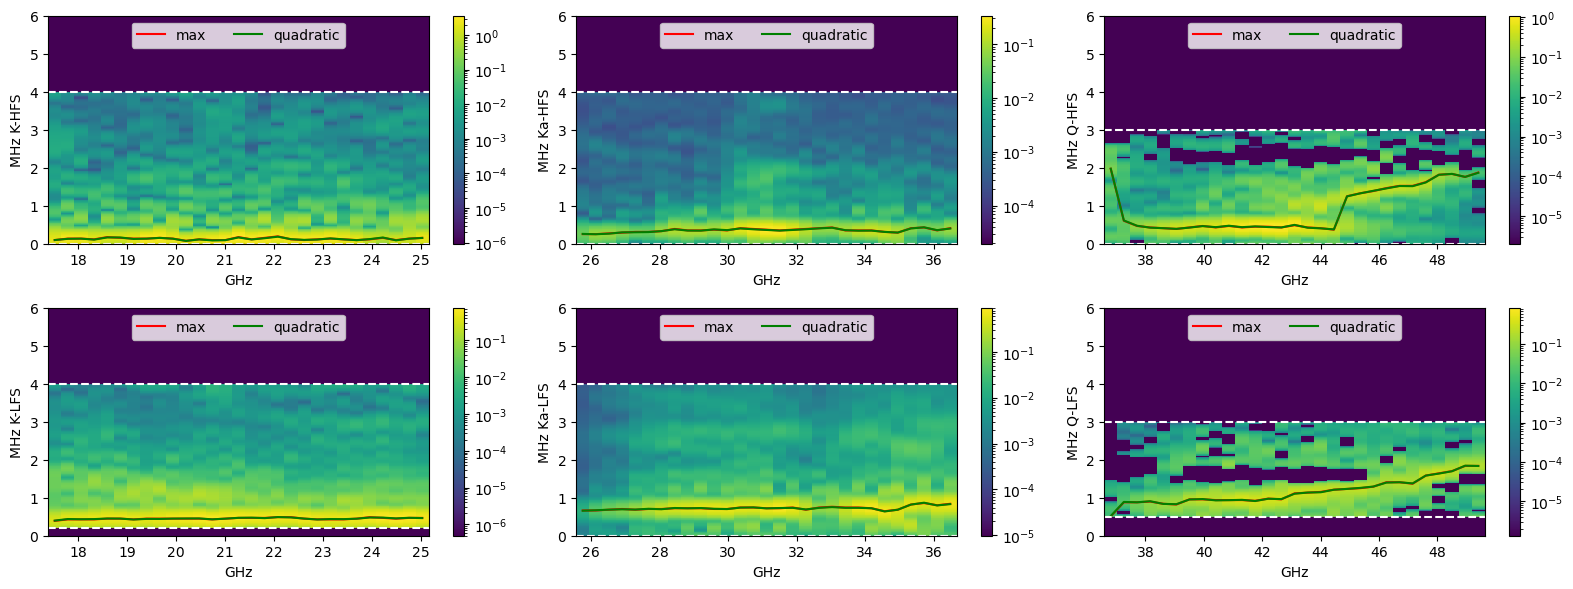

In [17]:
fig, axes = plt.subplots(2, len(used_bands), figsize=(16, 6))

for band, ax in zip(bands, axes.flatten()):
    plt.sca(ax)
    plt.pcolormesh(
        band.x * 1e-9, band.y_corrected * 1e-6, 
        np.clip(band.spectrogram_filtered, a_min=np.min(band.burst_spectrogram), a_max=np.inf),
        shading='nearest',
        norm=colors.LogNorm(vmin=band.burst_spectrogram.min(), vmax=band.burst_spectrogram.max()),
    )
    plt.colorbar()
    plt.ylabel(f"MHz {band.name}-{band.side}")
    plt.xlabel(f"GHz")
#     plt.pcolormesh(band.x * 1e-9, band.y_corrected * 1e-6, band.spectrogram_corrected, shading='nearest', norm=colors.LogNorm(vmin=band.burst_spectrogram.min(), vmax=band.burst_spectrogram.max()))
#     plt.plot(band.x * 1e-9, band.dispersion * 1e-6, color='C1')
#     plt.xlim(None, 47)
    plt.ylim(0, 6)
    plt.plot(band.x * 1e-9, band.max_beat_frequency*1e-6, color='red', label="max")
    plt.plot(band.x * 1e-9, band.estimate_maximum_frequency*1e-6, color='green', label="quadratic")
    plt.legend(loc="upper center", ncols=2)
    try:
        u, l = band.upper_filter, band.lower_filter
        plt.axhline(u*1e-6, color='w', ls='--')
        plt.axhline(l*1e-6, color='w', ls='--')
    except AttributeError:
        pass
    
    
plt.tight_layout()

# Set up exclusion regions

In [18]:
# Set up exclusion regions
exclude_hfs =[
    [36.5e9, 38e9],
#     [49e9, 55e9],
#     [73e9, 80e9],
#     [48.5e9, 55.5e9],
#     [48e9, 62e9],
]

exclude_lfs =[
#     [16e9, 18e9],
#     [49e9, 59e9],
#     [49e9, 55e9],
#     [73e9, 80e9],
#     [48e9, 58e9],
#     [53e9, 57e9],
]

try:
    regions_of_fit_lfs = [[0, exclude_lfs[0][0]], *[[exclude_lfs[i][1], exclude_lfs[i+1][0]] for i in range(len(exclude_lfs) - 1)], [exclude_lfs[-1][1], 80e9]]
except IndexError:
    regions_of_fit_lfs = [[0, 80e9]]

try:
    regions_of_fit_hfs = [[0, exclude_hfs[0][0]], *[[exclude_hfs[i][1], exclude_hfs[i+1][0]] for i in range(len(exclude_hfs) - 1)], [exclude_hfs[-1][1], 80e9]]
except IndexError:
    regions_of_fit_hfs = [[0, 80e9]]


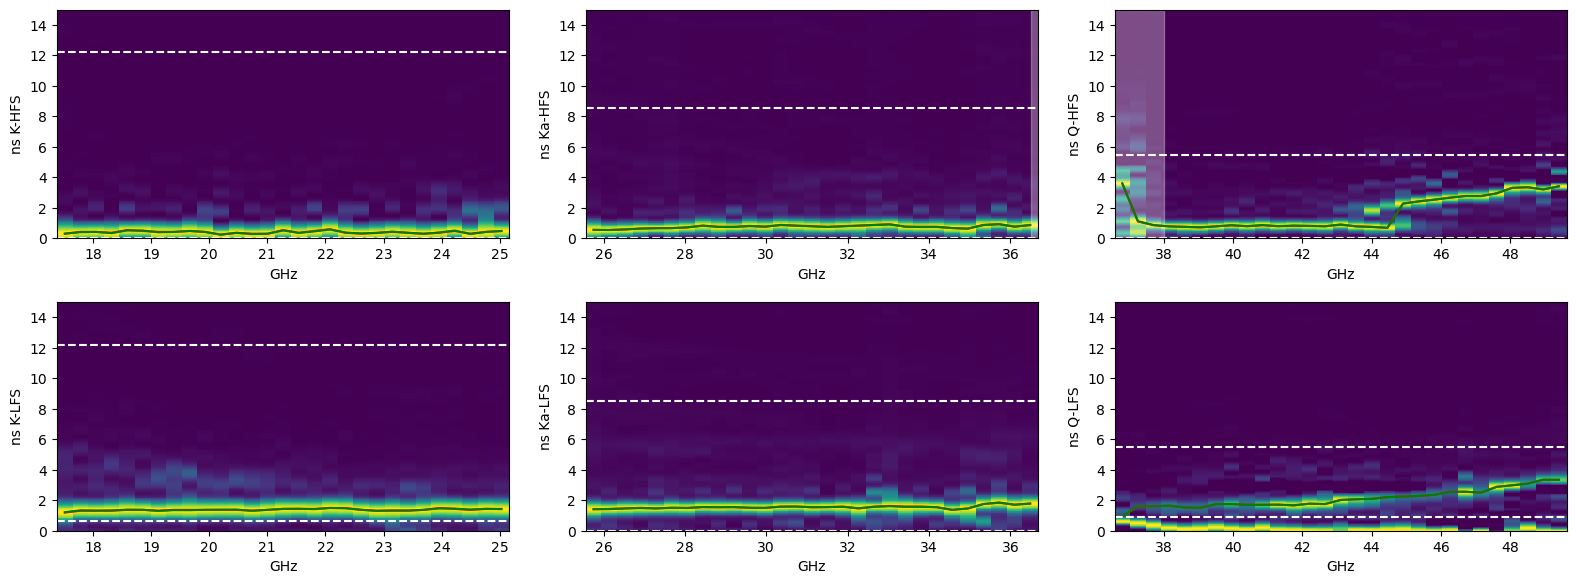

In [19]:
fig, axes = plt.subplots(2, len(used_bands), figsize=(16, 6))
axes = axes.flatten()

for band, ax in zip(bands, axes):
    plt.sca(ax)
    plt.pcolormesh(band.x * 1e-9, band.y_corrected / band.sweep_rate * 1e9, normalize(np.clip(band.spectrogram_corrected, a_min=0, a_max=np.inf), axis=0), shading='nearest')
    plt.plot(band.x * 1e-9, band.max_beat_frequency / band.sweep_rate * 1e9, color='red')
    plt.plot(band.x * 1e-9, band.estimate_maximum_frequency / band.sweep_rate * 1e9, color='green')
    plt.ylabel(f"ns {band.name}-{band.side}")
    plt.xlabel(f"GHz")
    try:
        u, l = band.upper_filter, band.lower_filter
        plt.axhline(u / band.sweep_rate * 1e9, color='w', ls='--')
        plt.axhline(l / band.sweep_rate * 1e9, color='w', ls='--')
    except AttributeError:
        pass

    plt.ylim(0.0, 15)
#     plt.grid()
     
for i in range(len(axes)//2):
    for ax, region in zip([axes[i], axes[i + len(axes)//2]], [exclude_hfs, exclude_lfs]):
        plt.sca(ax)
        xlim = plt.xlim()
        for l, u in region:
            ax.axvspan(l*1e-9, u*1e-9, color='white', alpha=0.3)
        plt.xlim(xlim)

#     plt.plot(band.x * 1e-9, band.dispersion * 1e-6, color='C1')
#     plt.xlim(None, 47)
    
    
plt.tight_layout()

# Join group delays from different bands and extend to zero

In [20]:
fp_hfs = np.concatenate([np.concatenate([x[(x > l) & (x < u)] for l, u in regions_of_fit_hfs]) for x in [band.x for band in bands[0: len(bands)//2]]])
gd_hfs = np.concatenate([np.concatenate([y[(x > l) & (x < u)] for l, u in regions_of_fit_hfs]) for y, x in [(band.tau, band.x) for band in bands[0: len(bands)//2]]])

fp_lfs = np.concatenate([np.concatenate([x[(x > l) & (x < u)] for l, u in regions_of_fit_lfs]) for x in [band.x for band in bands[len(bands)//2:]]])
gd_lfs = np.concatenate([np.concatenate([y[(x > l) & (x < u)] for l, u in regions_of_fit_lfs]) for y, x in [(band.tau, band.x) for band in bands[len(bands)//2:]]])

# Initialize linearly from limiter ----------------------------------------

def extrapolate_gd(fp, gd, gd_at_zero, up_to):

    def linear(x, b):
        return gd_at_zero + b*b*x

    idx = (up_to > fp)

    p, e = curve_fit(linear, 1e-9*fp[idx], 1e9*gd[idx])

    fp_extrapolated = np.insert(fp, 0, np.linspace(0, fp[0], 20)[:-1])
    gd_extrapolated = np.insert(gd, 0, 1e-9 * linear(1e-9 * fp_extrapolated[:20 - 1], *p))

    return fp_extrapolated, gd_extrapolated


fp_hfs, gd_hfs = extrapolate_gd(fp_hfs, gd_hfs, hfs_gd_zero, up_to=19.5e9)

fp_lfs, gd_lfs = extrapolate_gd(fp_lfs, gd_lfs, lfs_gd_zero, up_to=19.5e9)


# Stitch gd between gaps -------------------------------------------

def stitch_gd(fp, gd, down_from, up_to):
    
    def linear(x, a, b):
        return a + b*x
    
    idx = (up_to > fp) & (down_from < fp)
    
    fp_view = fp[idx]
    gd_view = gd[idx]
    
    break_point = np.argmax(np.diff(fp_view))
    print(1e-9 * np.max(np.diff(fp_view)))
    
    p, e = curve_fit(linear, 1e-9*fp_view, 1e9*gd_view)
    
    stitching = np.linspace(fp_view[break_point], fp_view[break_point + 1], 20)[1:-1]    
    stitch_point = len(fp_view) - 1
    
    fp_stitched = np.insert(fp, stitch_point + break_point, stitching)
    gd_stitched = np.insert(gd, stitch_point + break_point, 1e-9 * linear(1e-9 * stitching, *p))
    
    return fp_stitched, gd_stitched


# HFS -------------------------------------------------------------------------  
hfs_stitchings = [
#     [35.5e9, 39e9],
#     [47.5e9, 57e9],
]  

# LFS -------------------------------------------------------------------------  
lfs_stitchings = [
#     [33e9, 39e9],
#     [52e9, 58e9],
]  



for l, u in hfs_stitchings:
    fp_hfs, gd_hfs = stitch_gd(fp_hfs, gd_hfs, down_from=l, up_to=u)
    
for l, u in lfs_stitchings:
    fp_lfs, gd_lfs = stitch_gd(fp_lfs, gd_lfs, down_from=l, up_to=u)


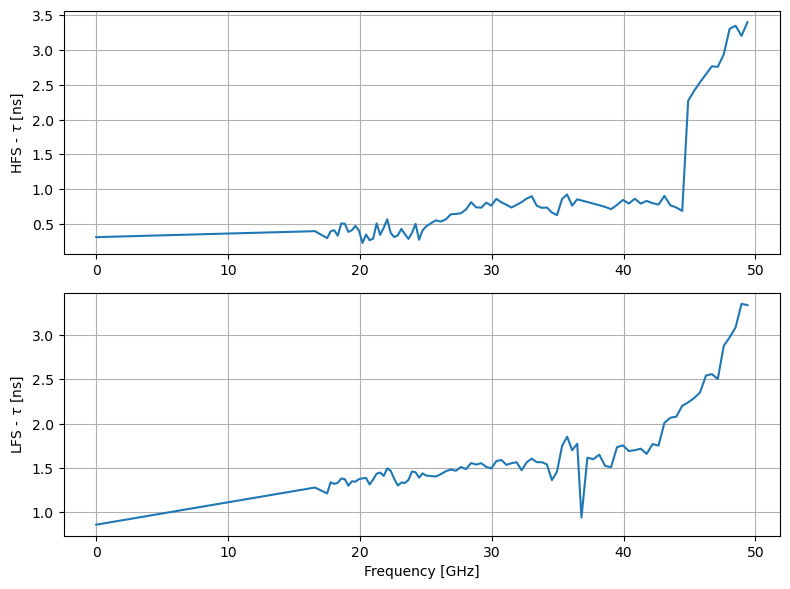

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

for i, (ax, fp, gd) in enumerate(zip(axes.flatten(), [fp_hfs, fp_lfs], [gd_hfs, gd_lfs])):
    plt.sca(ax)
    plt.grid()
#     plt.scatter(fp*1e-9, gd*1e9, s=3)
    plt.plot(fp*1e-9, gd*1e9)
    
axes[0].set_ylabel(r"HFS - $\tau$ [ns]")
axes[1].set_ylabel(r"LFS - $\tau$ [ns]")
#     plt.xlim(17.5, 25)
#     plt.ylim(0.5, 2)

# for band in bands:
#     arr = np.load(f"batch_{band.side}_{band.name}.npy")
#     if band.side == 'HFS':
#         ax = axes[0]
#     else:
#         ax = axes[1]
    
#     ax.plot(arr[0]*1e-9, arr[1]*1e9)
    
# for ax, r in zip(axes, [regions_of_fit_hfs, regions_of_fit_lfs]):
#     for l, u in r:
#         ax.axvspan(l*1e-9, u*1e-9, color='black', alpha=0.2)
        
plt.xlabel("Frequency [GHz]")

# plt.xlim(17.5, 25)
# plt.ylim(0.5, 2)
    
plt.tight_layout()

In [22]:
hfs_antenna = get_antenna_position('hfs')
lfs_antenna = get_antenna_position('lfs')

zl = 0.14  # Antenna height on LFS
zh = 0.07  # Antenna height on HFS

# Resample the frequency and group-delay
f_hfs = np.arange(0, fp_hfs.max(), 0.5e9)
gds_hfs = griddata(fp_hfs, gd_hfs, f_hfs)

r_hfs = profile_inversion(f_hfs, gds_hfs)
r_hfs = r_hfs + hfs_antenna


f_lfs = np.arange(0, fp_lfs.max(), 0.5e9)
gds_lfs = griddata(fp_lfs, gd_lfs, f_lfs)

r_lfs = profile_inversion(f_lfs, gds_lfs)
r_lfs =  - r_lfs + lfs_antenna

rho_hfs = fast_trz_to_rhop(time_instant, r_hfs, z=zh, shot=shot, equilibrium='EQH')
rho_lfs = fast_trz_to_rhop(time_instant, r_lfs, z=zl, shot=shot, equilibrium='EQH')

10:58:29 | aug_sfutils.sfread | INFO: Fetching SF /shares/experiments/aug-shotfiles/augd/EQH/40/40083.1
10:58:30 | aug_sfutils.sf2equ | INFO: Reading equ scalars
10:58:30 | aug_sfutils.sf2equ | INFO: Reading equ 1d profiles
10:58:31 | aug_sfutils.sf2equ | INFO: Reading equ PFM
10:58:31 | aug_sfutils.sf2equ | INFO: COCO 17
/shares/departments/AUG/users/danielhfc/python/ipfnpytools/ipfnpytools/trz_to_rhop.py:61: RuntimeWarning: invalid value encountered in sqrt
  values=np.array(np.sqrt((eq.pfm - eq.psi0)/(eq.psix-eq.psi0)), dtype=np.float32),
10:58:31 | aug_sfutils.sfread | INFO: Fetching SF /shares/experiments/aug-shotfiles/augd/EQH/40/40083.1
10:58:32 | aug_sfutils.sf2equ | INFO: Reading equ scalars
10:58:32 | aug_sfutils.sf2equ | INFO: Reading equ 1d profiles
10:58:32 | aug_sfutils.sf2equ | INFO: Reading equ PFM
10:58:32 | aug_sfutils.sf2equ | INFO: COCO 17


# Profiles in R[m]

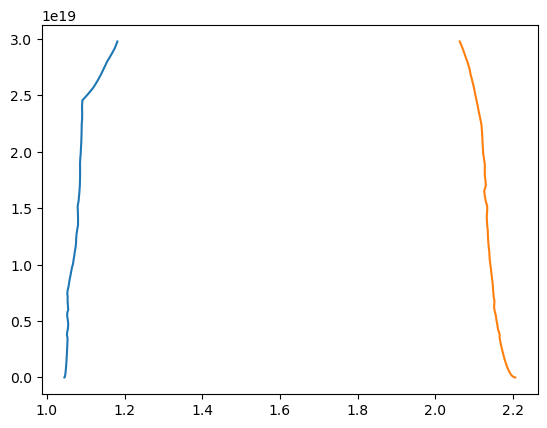

In [23]:
plt.figure()
plt.plot(r_hfs, f_to_ne(f_hfs))
plt.plot(r_lfs, f_to_ne(f_lfs))
# plt.xlim(1, 1.2)
# plt.plot(r_hfs, f_hfs)

# Profiles in $\rho$-poloidal

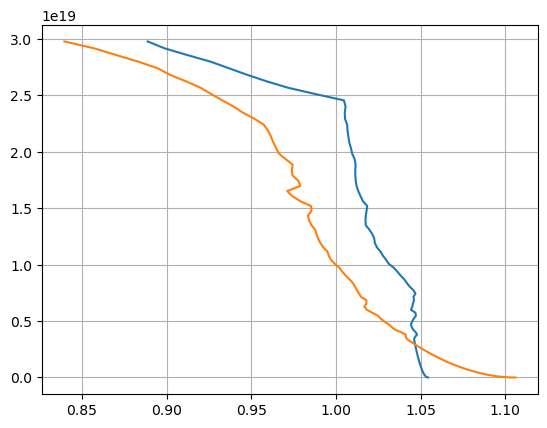

In [24]:
plt.figure()
plt.plot(rho_hfs, f_to_ne(f_hfs))
plt.plot(rho_lfs, f_to_ne(f_lfs))
plt.grid()

# Smooth

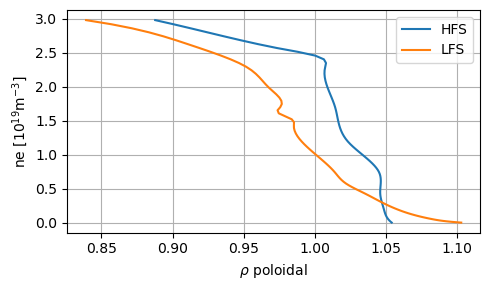

In [25]:
p_lfs = UnivariateSpline(f_to_ne(f_lfs), rho_lfs, s=10e-5)(f_to_ne(f_lfs))
p_hfs = UnivariateSpline(f_to_ne(f_hfs), rho_hfs, s=10e-5)(f_to_ne(f_hfs))

plt.figure(figsize=(5, 3))
plt.plot(p_hfs, f_to_ne(f_hfs)*1e-19, label='HFS')
plt.plot(p_lfs, f_to_ne(f_lfs)*1e-19, label='LFS')
plt.grid()
plt.legend()

# plt.ylim(0.3, None)
# plt.xlim(None, 1.1)
plt.xlabel(r"$\rho$ poloidal")
plt.ylabel(r"ne [10$^{19}$m$^{-3}$]")

plt.tight_layout()